In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout

In [3]:
# Load the training data
# Load the training data
column_names = ['unit', 'time', 'op1', 'op2', 'op3'] + [f'sensor_{i}' for i in range(1, 22)]
train_df = pd.read_csv("Predictive Maintaince/train_FD001.txt",sep='\s+', header=None, names=column_names)

train_df.head()

,unit,time,op1,op2,op3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [4]:
# Get the max cycle for each engine
rul_per_engine = train_df.groupby("unit")["time"].max().reset_index()
rul_per_engine.columns = ["unit", "max_cycle"]

# Merge to calculate RUL per row
train_df = train_df.merge(rul_per_engine, on="unit")
train_df["RUL"] = train_df["max_cycle"] - train_df["time"]

train_df[["unit", "time", "RUL"]].head()

,unit,time,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


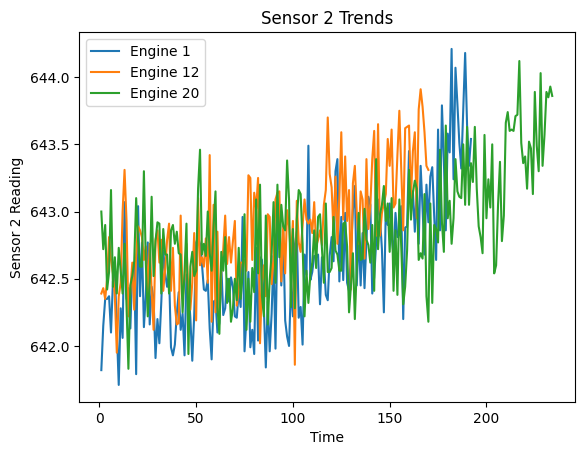

In [5]:
# Plot 3 sample engines' sensor 2
for unit_id in [1, 12, 20]:
    engine_data = train_df[train_df['unit'] == unit_id]
    plt.plot(engine_data["time"], engine_data["sensor_2"], label=f"Engine {unit_id}")

plt.xlabel("Time")
plt.ylabel("Sensor 2 Reading")
plt.title("Sensor 2 Trends")
plt.legend()
plt.show()

In [6]:
sensor_columns=[col for col in train_df.columns if 'sensor_' in col]
scaler=MinMaxScaler()
train_df[sensor_columns]=scaler.fit_transform(train_df[sensor_columns])
train_df.head()

,unit,time,op1,op2,op3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,max_cycle,RUL
0,1,1,-0.0007,-0.0004,100.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,192,191
1,1,2,0.0019,-0.0003,100.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,192,190
2,1,3,-0.0043,0.0003,100.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,192,189
3,1,4,0.0007,0.0000,100.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,192,188
4,1,5,-0.0019,-0.0002,100.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,192,187


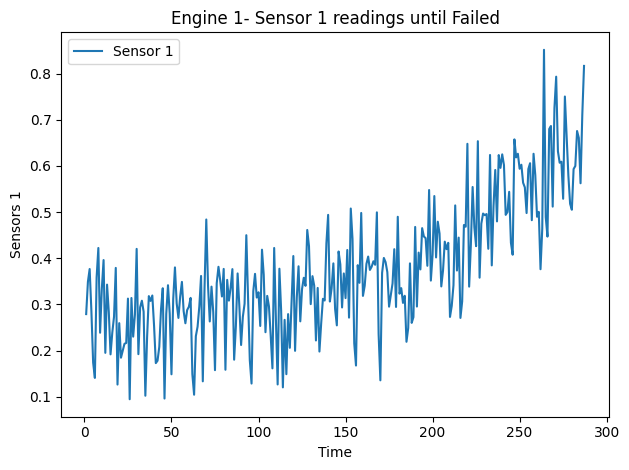

In [7]:
engine=train_df[train_df['unit']==2]
plt.plot(engine['time'],engine['sensor_3'],label=f"Sensor {1}")
plt.xlabel('Time')
plt.ylabel('Sensors 1')
plt.title("Engine 1- Sensor 1 readings until Failed")
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
def gen_sequences(id_unit,seq_length,sensor_columns):
    data_matrix=id_unit[sensor_columns].values
    sequences=[]
    for start in range(len(data_matrix)-seq_length):
        sequences.append(data_matrix[start:seq_length+start])
    return sequences
unit_ids = train_df["unit"].unique()
sequences = []

for unit_id in unit_ids:
   seqs = gen_sequences(train_df[train_df['unit'] == unit_id], 30, sensor_columns)
   sequences.append(seqs)

all_engines_sequences = list(zip(unit_ids, sequences))

In [9]:
X_train = []
y_train = []

seq_length = 30  # Already decided

for unit in train_df["unit"].unique():
    unit_df = train_df[train_df["unit"] == unit]
    unit_sequences = gen_sequences(unit_df, seq_length, sensor_columns)

    # Target RULs: we get them starting from t=30 onward
    unit_ruls = unit_df["RUL"].values[seq_length:]

    X_train.extend(unit_sequences)
    y_train.extend(unit_ruls)

In [10]:
X_train = np.array(X_train)
y_train = np.array(y_train)

print(X_train.shape)  # should be (total_sequences, 30, 21)
print(y_train.shape)  # should be (total_sequences,)

(17631, 30, 21)
(17631,)


In [11]:
model =Sequential()

In [16]:
model.add(LSTM(64,input_shape=(30,21),return_sequences=False))

In [17]:
model.add(Dropout(0.2))

In [18]:
model.add(Dense(32,activation="relu"))

In [19]:
model.add(Dense(1))

In [20]:
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 64)             │        22,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,129 (94.25 KB)

 Trainable params: 24,129 (94.25 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)


Epoch 1/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 6620.2983 - val_loss: 5395.4224
Epoch 2/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 3440.6523 - val_loss: 3126.3213
Epoch 3/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 1374.7767 - val_loss: 1905.1871
Epoch 4/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 978.2717 - val_loss: 2304.2983
Epoch 5/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 947.3231 - val_loss: 1720.0270
Epoch 6/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 929.6893 - val_loss: 1647.5859
Epoch 7/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 907.9540 - val_loss: 1745.1257
Epoch 8/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 862.3056 - val_loss: 1627.9149
Epoch 9/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 885.7385 - val_loss: 1800.7150
Epoch 10/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 859.1295 - val_loss: 1569.7484
Epoch 11/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 865.0707 -

In [22]:
#Evaluating the Model

In [26]:
# Load the test data
test_df = pd.read_csv("Predictive Maintaince/test_FD001.txt", sep="\s+", header=None, names=column_names)

# Normalize sensor columns using the SAME scaler as training
test_df[sensor_columns] = scaler.transform(test_df[sensor_columns])

test_df.head()

,unit,time,op1,op2,op3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,0.0023,0.0003,100.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.646055,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834
1,1,2,-0.0027,-0.0003,100.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.739872,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827
2,1,3,0.0003,0.0001,100.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.699360,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348
3,1,4,0.0042,0.0000,100.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.573561,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110
4,1,5,0.0014,0.0000,100.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.737740,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377


In [27]:
# Load true RUL values
rul_df = pd.read_csv("Predictive Maintaince/RUL_FD001.txt", sep="\s+", header=None)
rul_df.columns = ["RUL"]

# Add unit numbers for alignment
rul_df["unit"] = range(1, len(rul_df) + 1)

rul_df.head()

,RUL,unit
0,112,1
1,98,2
2,69,3
3,82,4
4,91,5


In [28]:
# Group test set by unit and get last 30 cycles of each engine
def get_last_sequence_per_engine(test_df, sequence_length, sensor_columns):
    sequences = []
    engine_ids = test_df["unit"].unique()

    for engine_id in engine_ids:
        engine_df = test_df[test_df["unit"] == engine_id]
        if len(engine_df) >= sequence_length:
            last_seq = engine_df[sensor_columns].values[-sequence_length:]
            sequences.append(last_seq)
        else:
            # Padding with zeros if sequence is shorter than required
            pad = np.zeros((sequence_length - len(engine_df), len(sensor_columns)))
            padded_seq = np.vstack((pad, engine_df[sensor_columns].values))
            sequences.append(padded_seq)

    return np.array(sequences)

X_test = get_last_sequence_per_engine(test_df, 30, sensor_columns)
X_test.shape


(100, 30, 21)

In [29]:
# Predict RULs for test data
predicted_rul = model.predict(X_test).flatten()

# Convert to DataFrame for easier comparison
predicted_df = pd.DataFrame({
    'engine_id': test_df['unit'].unique(),
    'predicted_RUL': predicted_rul,
    'true_RUL': rul_df['RUL']
})

predicted_df.head()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


,engine_id,predicted_RUL,true_RUL
0,1,112.793869,112
1,2,142.623886,98
2,3,47.239605,69
3,4,78.270523,82
4,5,113.265594,91


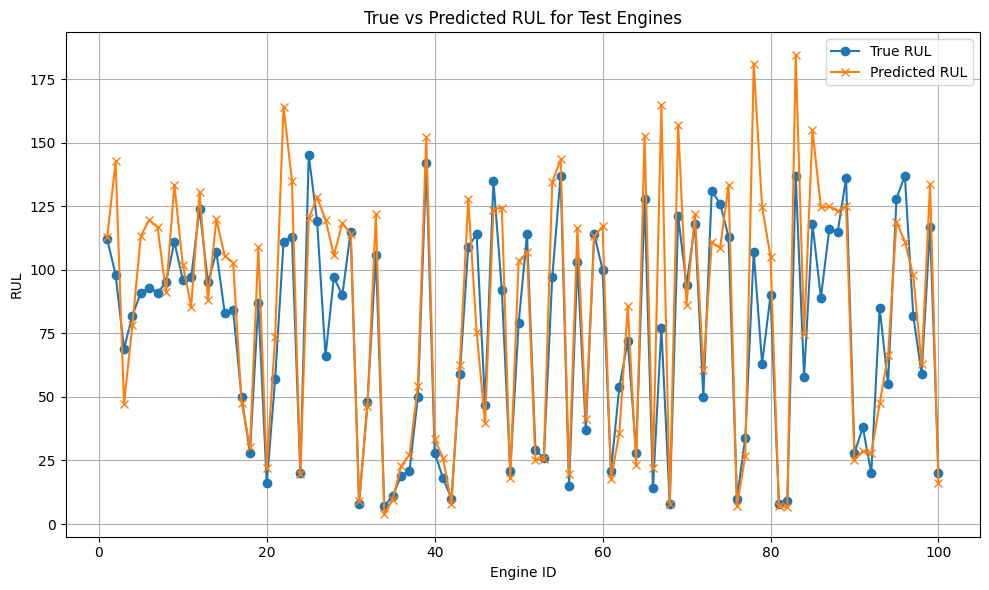

In [30]:
plt.figure(figsize=(10,6))
plt.plot(predicted_df["engine_id"], predicted_df["true_RUL"], label="True RUL", marker='o')
plt.plot(predicted_df["engine_id"], predicted_df["predicted_RUL"], label="Predicted RUL", marker='x')
plt.xlabel("Engine ID")
plt.ylabel("RUL")
plt.title("True vs Predicted RUL for Test Engines")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
